# Move over project demo
This notebook is the first attempt of applying detection and tracking system for move over projets
- objects are detected and tracked
- objects are visualized in the map
- objects at lanes are counted
- objects that changed lanes are counted


In [1]:
#! could clean up import organization visually
import cv2
import os
import sys
import numpy as np
import pickle

sys.path.insert(0,'../..')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from random import randint
import matplotlib.pyplot as plt

import socket


from pathlib import Path

from time import time
from cav.parameters import Parameters

#! not used
from cav.visualization import Map, plotBoxes

# Deep sort imports
from deep_sort import nn_matching
from deep_sort.tracker import Tracker
from deep_sort.detection import Detection
%matplotlib inline 

import config


In [2]:
#TOPOINT = 'BC'  ### Default value, Bottom center
#TOPOINT = 'BR5' ## Bottom Right

#! dont fully understand
TOPOINT = 'BL10' ## Bottom Left

## Deep sort

In [3]:
#! could move up
from moveoverlib.helper import ImageEncoder, create_box_encoder

In [4]:
#! need to comeback to understand ImageEncoder; not used
#! encoder used but much later in main loop
image_encoder = ImageEncoder(config.ENCODER_PATH, config.ENCODER_INPUT_NAME, config.ENCODER_OUTPUT_NAME)
encoder = create_box_encoder(config.ENCODER_PATH, batch_size=32)

## Create tracker

In [5]:
#! max distance from kth centroid?
max_cosine_distance = 0.2
#! only check first k distances per centroid?
nn_budget = 100

#! seems to init some sort of nn object
#! need to move down
metric = nn_matching.NearestNeighborDistanceMetric(
    "cosine", max_cosine_distance, nn_budget)

### Create params and map objects

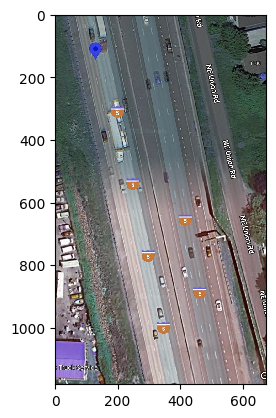

In [6]:
#! seems to create the map between camera and birds eye similar to in 02
#! params seem preset for the video; used for view translation
#! mymap seems different though, grouping the birds eye and detection icons?
params = Parameters()
params.generateParameters('./params.json')
mymap = Map('./images/SkyView.jpg', './icons_simple.json', params)
plt.imshow(mymap.getMap(), interpolation='nearest')
plt.show()

### Lane Controller

In [7]:
#! unsure, need to run to see how it works as lanes.py is poorly documented
from cav.lanes import Lanes
lanes_controller = Lanes('./images/mask.png', params=params)

### Saved detections

In [8]:
#! setting up paths for main loop
#! can clean up ordering to make more readable
#! don't understand save_detections, creates empty file then reads from it 
SAVE_DETECTIONS = f'{config.DATA_PATH}/detections.p'
FRAME_FOLDER = os.path.join(config.DATA_PATH, 'frames_raw/')
VIDEO_FILE = pickle.load(open(f'{config.DATA_PATH}/videopath.p', 'rb'))
print ('Video path:', VIDEO_FILE)

Path(FRAME_FOLDER).mkdir(parents=True, exist_ok=True)

save_detections = pickle.load(open(SAVE_DETECTIONS,'rb'))


Video path: ../../videos/vid_source.mp4


#### Logging parameters

In [9]:
SAVE_LOG = None #### Saves logs with all detected objects (path to file or none)

#! can try both; what info?
SAVE_LANES = None ###### Saves info about lanes
SAVE_LANES = './data/lanes_detections.csv' ###### Saves info about lanes

SKIP_FIRST = 0 # How many seconds in the beginning should be skipped

#### Other parameters

In [10]:
#! opens video file, gets metadata about video
cap = cv2.VideoCapture(VIDEO_FILE) 
FRAMES_SEC = cap.get(cv2.CAP_PROP_FPS)
VIDEO_X = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
VIDEO_Y = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 

#! hyperparams for detection
MAX_BOXES_TO_DRAW = 100       #! not 100% sure, max bb per frame?
MIN_SCORE_THRESH = 0.5        #! confidence thresh for classification?
IOU_COMMON_THRESHOLD = 0.50   #! same as above?
NOT_DETECTED_TRHESHOLD = 1    #! not sure

MAPSHAPE = mymap.getMap().shape
print ('Y dimension of map is {:.3f} larger than Y dimension of the video'
      .format(MAPSHAPE[0] / VIDEO_Y))

#! downsampling?
MAP_RESIZE = 3

print ('Y dimension of map is {:.3f} larger than Y dimension of the video. Size of the map is reduced {} times.'
      .format(MAPSHAPE[0] / VIDEO_Y, MAP_RESIZE))


FINAL_X = VIDEO_X + int(MAPSHAPE[1] / MAP_RESIZE)
FINAL_Y = max(VIDEO_Y, int(MAPSHAPE[0] / MAP_RESIZE))

print ('Video size: [{}, {}], Final size: [{}, {}]'
      .format(VIDEO_X, VIDEO_Y, FINAL_X, FINAL_Y))

RESIZE = False                #! not used

#! unclear, but pixel coords for video?
CROP_VID = False
VID_LEFT = 0
VID_RIGHT = 1920
VID_UP = 0

Y dimension of map is 1.094 larger than Y dimension of the video
Y dimension of map is 1.094 larger than Y dimension of the video. Size of the map is reduced 3 times.
Video size: [1920, 1080], Final size: [2145, 1080]


In [11]:
#! can prob delete
print (MAPSHAPE[0] / VIDEO_Y)

1.0935185185185186


In [12]:
#! why reopen? seems like didn't actually modify the video above
cap = cv2.VideoCapture(VIDEO_FILE) 

#! specifies video codec but not sure what XVID is
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = None              #! not used

objects = []

results = []            #! not used
colors = {}             #! not used

#! related to NN and BB but not sure how
tracker = Tracker(metric)

nr_skipped = 0          #! not used
i = 0
t = time()

#! why use a socket
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    # open lane log file to write to
    if SAVE_LANES is not None:
        logfile_lanes = open('{}'.format(SAVE_LANES), 'w')

    while cap.isOpened():
        # time since starting and stats
        t2 = time() - t
        sys.stdout.write('{} frames done in {:.1f} seconds ({:.2f} frames/sec)    \r'.format(
            i, t2, i/t2))                   
        
        frame_timeStamp = i/FRAMES_SEC      #! not used
        
        #! gets next frame; not sure what ret is maybe metadata
        ret, image = cap.read()

        # skips first k frames
        if i < SKIP_FIRST * FRAMES_SEC:
            i += 1
            continue
                
        # crops the video
        if CROP_VID:
            image = image[VID_UP:, VID_LEFT:VID_RIGHT, :]
        
        #! is save_detections a list of idxs := frames
        if i+1 not in save_detections:
            break
        
        #! even more confused as to what save_detections is
        #! reading in predone detections per frame?
        ###!!! what object is being saved in the save_detections file
        boxes, scores, classes = save_detections[i+1] 
        
        if len(boxes) >= 1:
            for box in boxes:
                if TOPOINT != 'BC':
                    box.setToPoint(TOPOINT)         #! find in box class?
                    
                box.updateParams(params)
            
            #! what are these bb? for
            boxes_array = [[box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop] for box in boxes]
            boxes_array = np.array(boxes_array)
            
            #! need to understand encoder
            bgr_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            features = encoder(bgr_image, boxes_array)
            detections = []

            #! reading in from save_detections file, makes Detection object
            for box, score, objClass, f_vector in zip(boxes, scores, classes, features):
                detection = Detection(
                    [box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop], #BBox
                    score, f_vector,
                    objClass
                )
                detection.bbox = box
                detections.append(detection)

            #! updates detections list directly?
            tracker.predict()
            tracker.update(detections)                
        
        #! if no boxes, what is being used to predict??
        else:
            tracker.predict()
            
        plotboxes = []
        plotcolors = []
        objects = []

        if len(tracker.tracks) >= 1:
            for track in tracker.tracks:
                #! huh? why not use break structure
                if not track.is_confirmed() or track.time_since_update >= 1:
                    continue

                #! what is the trackedObject - bb?
                obj = track.trackedObject

                if obj is not None:
                    if obj.color is None:
                        obj.color = (randint(0, 255), randint(0, 255), randint(0, 255))                        
                    plotbox = obj.bboxes[-1]
                    plotbox.trackId = track.track_id
                    plotboxes.append(plotbox)
                    plotcolors.append(obj.color)
                    objects.append(obj)
                    
                    if SAVE_LANES is not None:
                        #! need to look further into below class
                        lane = lanes_controller.addObject(obj)
                        if SAVE_LANES is not None:
                            log_line = '{},{},{}'.format(i, lane, obj.getParams(asCsv=True, speedLookback = 10))
                            print(log_line,file=logfile_lanes)                              

            #! plots bb and saves                                             
            if len(plotboxes) >= 1:
                vid = plotBoxes(image, plotboxes, colors=plotcolors)
            else:
                vid = image.copy()
            cv2.imwrite(os.path.join(FRAME_FOLDER, 'im_{}.jpg'.format(str(i).zfill(6))), vid)

        #! can clean up structure
        #! save objects
        if len(objects) > 0:        
            if SAVE_LOG is not None:
                logfile = open('./logs/{}'.format(SAVE_LOG, 'w'))
                for obj in objects:
                    #! error with True  
                    line = '{},{},{}'.format(i,time(),obj.getParams(asCsv=true))                     
                    print(line,file=logfile)                    
                                
        i = i+1
                
#! end stats video                  
t = time() - t                             
print('\n\n{} frames done in {:.1f} seconds ({:.2f} frames/sec)'.format(
    i, t, i/t))                             
cap.release()


2023-06-14 14:23:31.363496: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


903 frames done in 297.9 seconds (3.03 frames/sec)    

903 frames done in 297.9 seconds (3.03 frames/sec)
